# Playground

The goal of this project is to generate medical reports from X-ray images. The images are in grayscale. We will work on a few so-called *image2text* models.

In [5]:
# @TODO: evaluation, BLEU, https://github.com/tylin/coco-caption
# @TODO: plot number of sentences
# @TODO: plot avg sentence length
# @TODO: use larger encoder model (ViT-B/32, ViT-L/32, ViT-H/14) with 1024 hidden size

# @TODO: visualize conv filters
# @TODO: visualize attention

# @TODO: embedding (pre-trained?)

# @TODO: custom teacher forcing module, drop-in for GRU, LSTM, transformer(?): TeacherForcing(nn.GRU(), teachingRatio=.5)
# @TODO: compare against GPT-4 (with images) if possible
# @TODO: attention (cross-attention) using tags
# @TODO: extract tags

# references: https://arxiv.org/pdf/1711.08195v3.pdf, https://arxiv.org/pdf/2209.15323.pdf

In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("./code")

First the imports.

In [7]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

from tqdm import tqdm
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision.models import vgg19, vit_b_16, ViT_B_16_Weights

import logging
logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

import spacy
#!python -m spacy download en_core_web_lg

import stanza
stanza.download("en")

from utils import *
from dataset import *
from plots import *
from models import *

fix_seed()

05:12:11 - INFO: Downloading default packages for language: en (English) ...
05:12:12 - INFO: File exists: C:\Users\rasmu\stanza_resources\en\default.zip
05:12:17 - INFO: Finished downloading models and saved to C:\Users\rasmu\stanza_resources.


## Load data

Let's load the metadata and the images.

In [4]:
REPORT_PATH = "./data/raw/reports"
IMAGE_PATH = "./data/raw/images"

In [ ]:
metadata = load_reports(REPORT_PATH)
metadata.describe()

01:14:57 - INFO: found 3955 reports.


,image_name,comparison,indication,findings,impression
count,7470,6313,7311,6473,7418
unique,7470,394,2454,2553,1770
top,CXR1_1_IM-0001-3001.png,None.,Chest pain,The heart is normal in size. The mediastinum i...,No acute cardiopulmonary abnormality.
freq,1,1592,253,98,586


Notice, some of the text is censored by replacing words with "XXXX".

In [6]:
metadata.head()

,image_name,comparison,indication,findings,impression
0,CXR1_1_IM-0001-3001.png,None.,Positive TB test,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,CXR1_1_IM-0001-4001.png,None.,Positive TB test,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
2,CXR10_IM-0002-1001.png,Chest radiographs XXXX.,"XXXX-year-old male, chest pain.",The cardiomediastinal silhouette is within nor...,No acute cardiopulmonary process.
3,CXR10_IM-0002-2001.png,Chest radiographs XXXX.,"XXXX-year-old male, chest pain.",The cardiomediastinal silhouette is within nor...,No acute cardiopulmonary process.
4,CXR100_IM-0002-1001.png,None.,None,Both lungs are clear and expanded. Heart and m...,No active disease.


The feature "findings" describes the radiologists observations. While "impression" is the final diagnosis / conclusion.
Let's define a report as the concatation of the findings and impression text.

In [7]:
reports = prepare_reports(metadata)
reports.head()

01:15:00 - INFO: raw report length: 7470
01:15:00 - INFO: post-processing report length: 7430


0    The cardiac silhouette and mediastinum size ar...
1    The cardiac silhouette and mediastinum size ar...
2    The cardiomediastinal silhouette is within nor...
3    The cardiomediastinal silhouette is within nor...
4    Both lungs are clear and expanded. Heart and m...
Name: report, dtype: object

In [8]:
reports.describe()

count                                                  7430
unique                                                 3066
top       The heart is normal in size. The mediastinum i...
freq                                                     96
Name: report, dtype: object

Let's load the images. The images have been cropped such that the width and height are the same. Afterwards, the images have been downscaled to 256x256. 

In [9]:
# we'll only use a subset of the dataset in the *notebook* due to memory constraints. However, the scripts will use the full dataset.
N = 1000

metadata_subset = metadata[:N]
reports_subset = prepare_reports(metadata_subset)

images = load_images(metadata_subset, IMAGE_PATH, resized=(224, 224))
images = images[reports_subset.index]

01:15:00 - INFO: raw report length: 1000
01:15:00 - INFO: post-processing report length: 992


There are images from two views: frontal and lateral. It may be worth to include this information in the model. However, since the view hasn't already been annotated, we will ignore it for now.

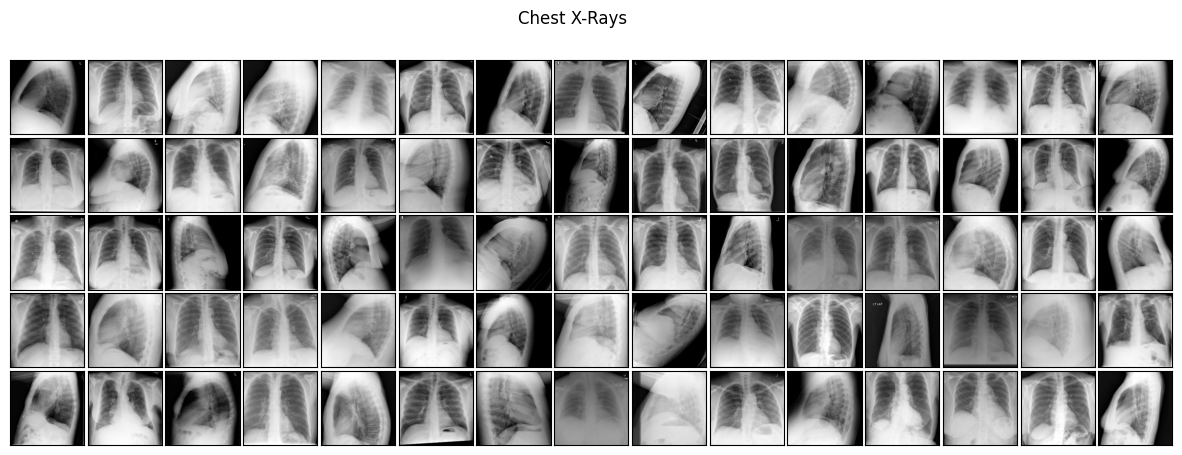

In [10]:
offset = 100
n_rows = 5
n_cols = 15

images_tiny = images[offset:offset+n_rows*n_cols]

plot_images_2d(images_tiny.reshape(n_rows, n_cols, *images_tiny.shape[1:]), "Chest X-Rays")

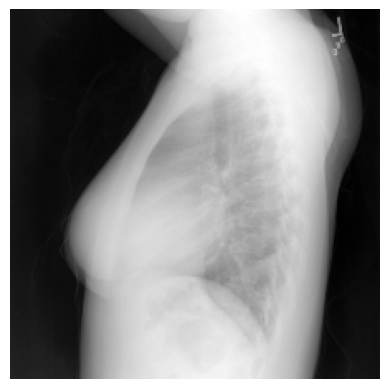

In [20]:
highlighted_image = images[0]
plot_image(highlighted_image)

Time to plot a few random X-ray image and their corresponding reports!

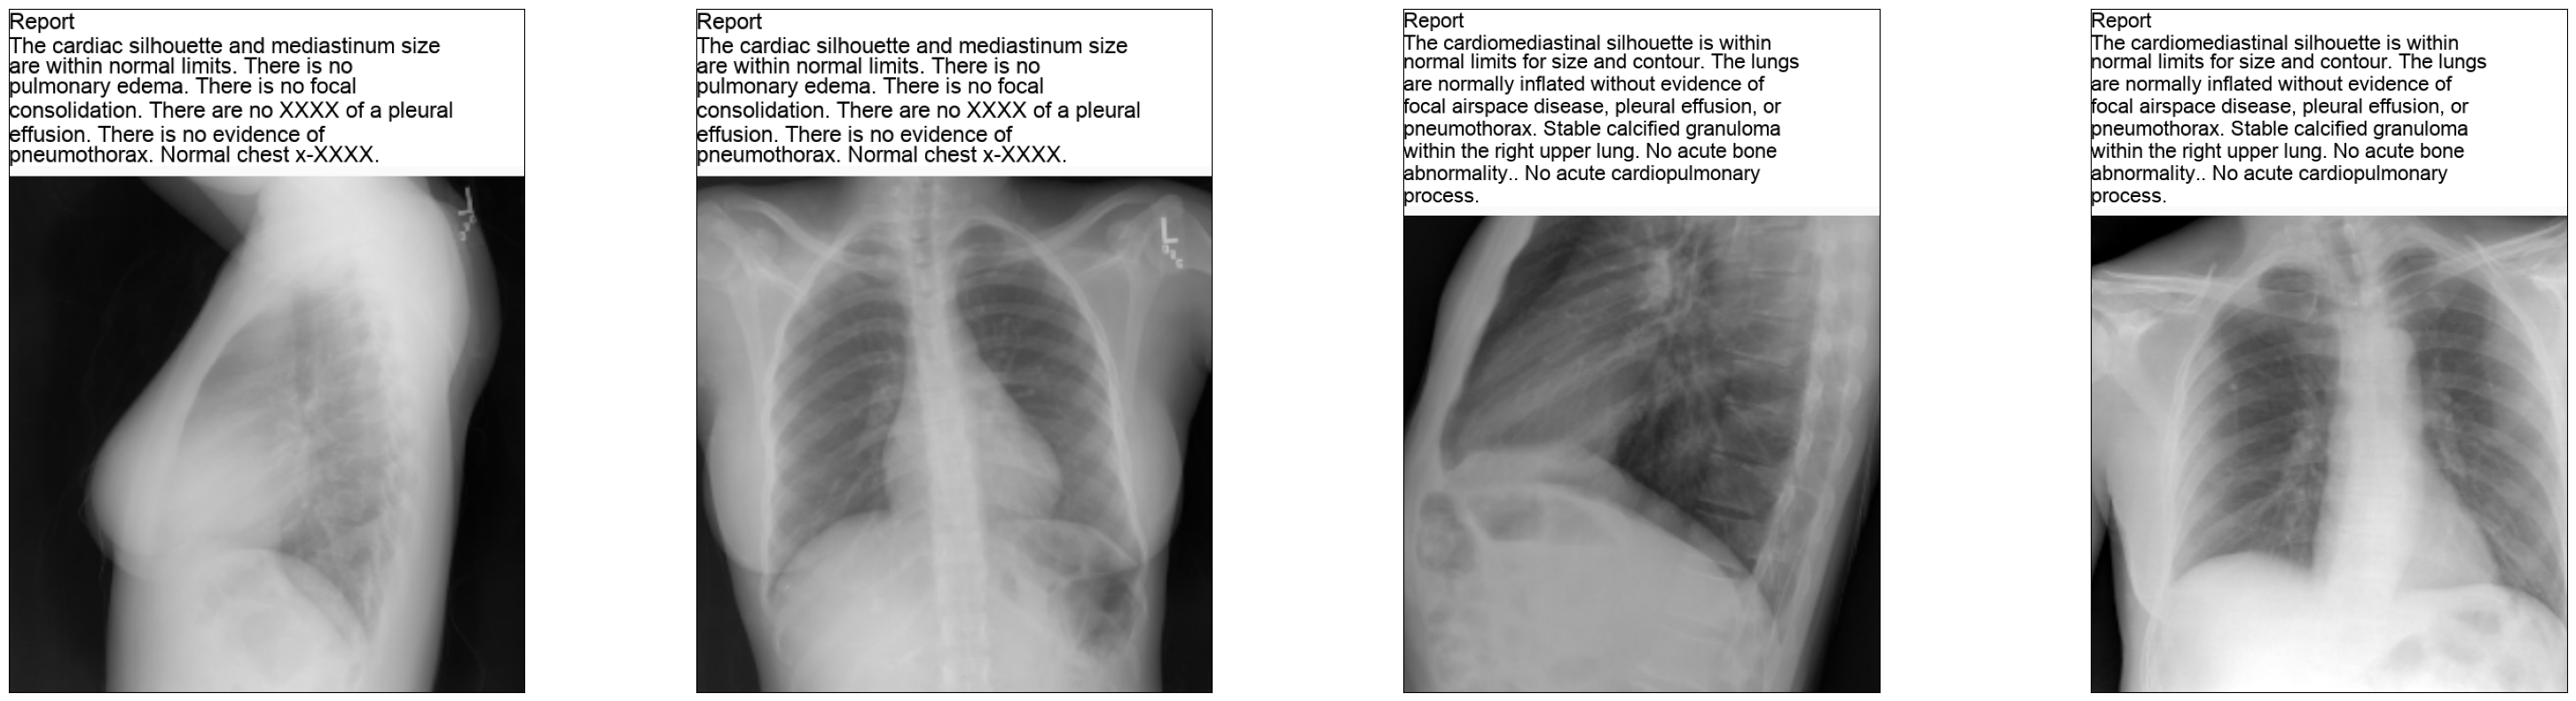

In [21]:
k = np.arange(4) #1400

title = "Report"
extracted_textbodies = reports.iloc[k]
extracted_images = images[k].numpy()

plot_multiple_text_and_images(extracted_textbodies, title, extracted_images)

## Preprocessing

### Images

Images are already normalized the range [0, 1].

### Text

Let's tokenize the reports.

In [22]:
#tokenizer = spacy_tokenizer()
tokenizer = stanza_tokenizer()

tokenized_reports = reports.apply(lambda text : tokenize(text, tokenizer))

01:17:46 - INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
01:17:46 - INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

01:17:46 - INFO: Using device: cpu
01:17:46 - INFO: Loading: tokenize
01:17:46 - INFO: Done loading processors!


And time for some statistics:

In [23]:
tokenized_reports.head()

0    [the, cardiac, silhouette, and, mediastinum, s...
1    [the, cardiac, silhouette, and, mediastinum, s...
2    [the, cardiomediastinal, silhouette, is, withi...
3    [the, cardiomediastinal, silhouette, is, withi...
4    [both, lungs, are, clear, and, expanded, ., he...
Name: report, dtype: object

In [24]:
tokenized_reports_lengths = tokenized_reports.apply(len)

print(f"Report length: {np.mean(tokenized_reports_lengths):.1f} +- {np.std(tokenized_reports_lengths):.1f} words.")
print(f"Report length boundaries: [{np.min(tokenized_reports_lengths):.1f}; {np.max(tokenized_reports_lengths):.1f}] words.")

Report length: 43.4 +- 21.7 words.
Report length boundaries: [3.0; 255.0] words.


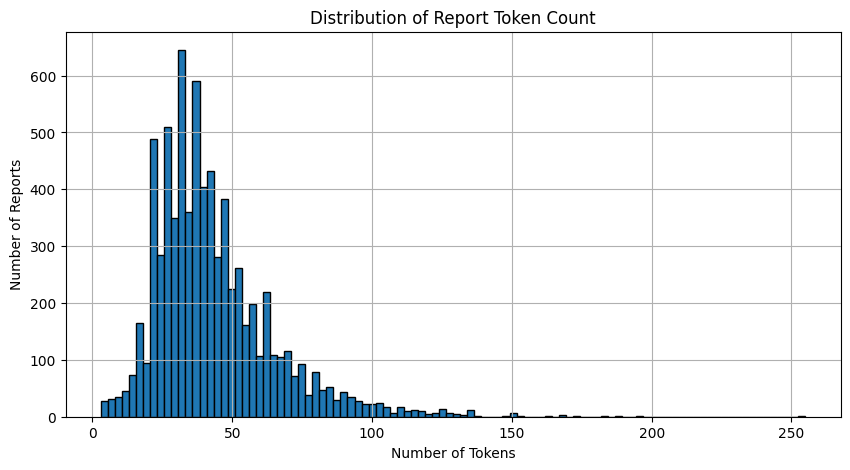

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(tokenized_reports_lengths, bins=100, histtype="bar", ec="black")
ax.set_title("Distribution of Report Token Count")
ax.set_xlabel("Number of Tokens")
ax.set_ylabel("Number of Reports")
ax.grid()
plt.show()

In [26]:
vocabulary = build_vocabulary([token for tokens in tokenized_reports for token in tokens])
print(f"vocabulary size: {len(vocabulary)} tokens")

token2id, id2token = map_token_and_id_fn(vocabulary)

vocabulary size: 1933 tokens


## Models

In [ ]:
model_name = "playground"
model = XRayPlaygroundModel(len(vocabulary))

#model_name = "vit"
#model = XRayViTModel(len(vocabulary))

images_ready = model.encoder.preprocess(images)

train_split = .9
train_size = int(len(images) * train_split)

train_dataset = XRayDataset(images_ready[:train_size], tokenized_reports[:train_size], token2id)
validation_dataset = XRayDataset(images_ready[train_size:], tokenized_reports[train_size:], token2id)

train(model_name, model, vocabulary, train_dataset, validation_dataset, epochs=5)

In [256]:
result = load_dict(os.path.join("results", model_name, "result.pkl"))

train_losses = result["train_losses"]
validation_losses = result["validation_losses"]

perplexity = lambda loss: np.exp(loss)
print(f"perplexity | train: {perplexity(np.mean(train_losses))}, validation: {perplexity(np.mean(validation_losses))}, random: {perplexity(-np.log(1. / len(vocabulary)))}")

perplexity | train: 11.21021842956543, validation: 15.148070335388184, random: 1933.0


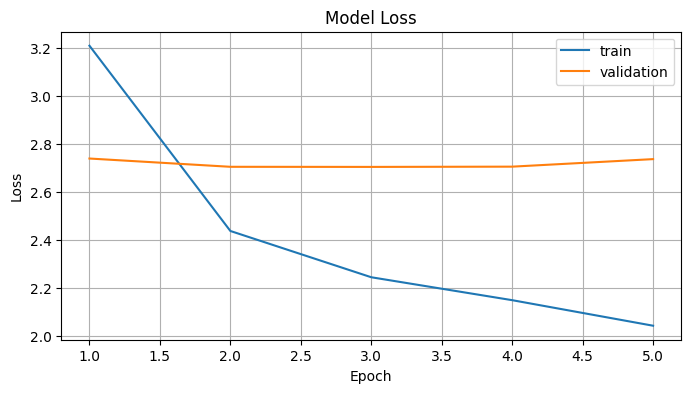

In [246]:
plot_losses(train_losses, validation_losses)

In [247]:
# @TODO: beam search, maybe show distribution of how certain the model is for the next word using pytorch interactive
def generate_tokens(model, image, max_length=200, gen_type="random"):
    report = []

    with torch.no_grad():
        model.eval()

        text_start = torch.tensor(token2id("[START]"))[None,None]
        image = image[None]

        input = text_start
        context = model.encoder(image)

        for i in range(max_length):
            output, hidden = model.decoder(input, context)
            output = output[0]

            if gen_type == "greedy":
                output = output.argmax(dim=-1)
            elif gen_type == "random":
                probs = F.softmax(output[0], dim=-1)
                probs = probs.numpy().astype('float64')
                probs /= np.sum(probs)
                select = np.random.choice(len(output[0]), p=probs)
                output = torch.tensor([select])
            else:
                raise Exception("invalid strategy")

            token = id2token(output.item())

            if token == "[END]":
                break

            report.append(token)
            
            input = output[None]
            context = hidden[0]

    return report

In [261]:
model = XRayPlaygroundModel(len(vocabulary))
model.load_state_dict(torch.load(os.path.join("results", model_name, "model.pt"), map_location=torch.device("cpu")))

sample = train_dataset[0]

xray = sample[0]
report_ids = sample[1]

report_tokens = [id2token(token) for token in report_ids[1:-1]]
report_est_tokens = generate_tokens(model, xray)

report = tokens_to_text(report_tokens)
report_est = tokens_to_text(report_est_tokens)

print(f"true: {report}")
print(f"guess: {report_est}")

true: the cardiac silhouette and mediastinum size are within normal limits. there is no pulmonary edema. there is no focal consolidation. there are no xxxx of a pleural effusion. there is no evidence of pneumothorax. normal chest.
guess: the heart and left without clear for mildly xxxx opacity of first. suspicion and minimally is within normal highly heart tract and there are volumes upper. left normal informative abnormality the lungs are clear chest is chest size chronic. clear lung mild removed. skeletal focal silhouette post or active. over or pneumothorax effusion appear. with mediastinum is normal limits. no acute cardiomediastinal xxxx osseous.


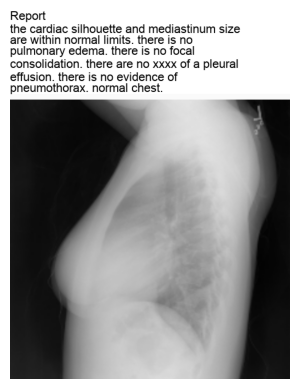

In [253]:
xray_plotable = (xray[0] * 255).numpy()
plot_text_and_image(report, "Report", xray_plotable)